In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss, confusion_matrix
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
#read raw data
restaurant = pd.read_csv("DOHMH_New_York_City_Restaurant_Inspection_Results.csv", dtype = {'ZIPCODE':str, 'PHONE':str}, parse_dates = ['INSPECTION DATE', 'GRADE DATE', 'RECORD DATE'])

#target variable investigation
restaurant['target'] = restaurant['GRADE'].fillna('NaN')
#exclude non-informatively labeled records
res_USE = restaurant[(restaurant['target'] != 'NaN') & (restaurant['target'] != 'Not Yet Graded') ]



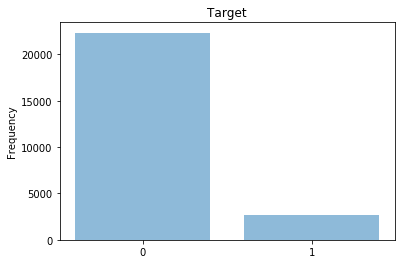

In [66]:
#exclude features that should not be used in predictive modeling of grade
#ACTION, VIOLATION CODE, VIOLATION DESCRIPTION, CRITICAL FLAG, SCORE, INSPECTION TYPE
res_Sel = res_USE.drop(['ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'INSPECTION TYPE', 'RECORD DATE'], axis = 1)

#exclude Grade Date missing
res_Sel2 = res_Sel[-res_Sel['GRADE DATE'].isnull()]

res_Sel2 = res_Sel2.sort_values(by = ['CAMIS', 'GRADE DATE'], ascending = [1, 0])

#drop dupliated restaurant records, retrieve the latest record
res_Sel3 = res_Sel2.drop_duplicates(['CAMIS']).reset_index()



#generate binary class label:either A(0) or not(rare, 1)
res_Sel3['target'] = res_Sel3['target'].map(lambda x: 0 if x == 'A' else 1)
y_tables = res_Sel3['target'].value_counts()
y_pos = np.arange(len(y_tables.values))
plt.bar(y_pos, y_tables.values, align='center', alpha=0.5)
plt.xticks(y_pos, list( y_tables.index))
plt.ylabel('Frequency')
plt.title('Target')
plt.show()

In [87]:
boro = pd.get_dummies(res_Sel3['BORO'], drop_first = True)

zipcode = pd.get_dummies(res_Sel3['ZIPCODE'], drop_first = True)

cusine = pd.get_dummies(res_Sel3['CUISINE DESCRIPTION'], drop_first = True)

model_data = pd.concat([res_Sel3['target'], boro, zipcode, cusine], axis = 1)


#partition data 70% for modeling, 30% for holdout
Xtrain, Xhold, ytrain, yhold = train_test_split(model_data.drop(['target'], axis = 1), model_data['target'], test_size = 0.3, random_state = 42)

In [142]:
#using weighted regularized logistic regression
lr_estimator = LogisticRegression()
param_test = {'C':[0.0001, 0.01, 1, 100], 'class_weight':[{1: 9}, {1: 8}, {1: 7}, {1: 6}, {1: 5}, {1: 4}]}
glr = GridSearchCV(lr_estimator, param_grid = param_test, cv = 5, scoring = 'f1')
glr = glr.fit(Xtrain, ytrain)
blr = glr.best_estimator_.fit(Xtrain,ytrain)

print (glr.best_params_)
lr_score = glr.best_score_
print ('f1 score: ', lr_score)

#joblib.dump(blr, 'ori_lr.pkl')

{'class_weight': {1: 8}, 'C': 0.01}
f1 score:  0.233768044763


['ori_lr.pkl']

In [143]:
#using weighted random forest
rf_estimator = RandomForestClassifier(max_leaf_nodes = 200, min_samples_leaf = 10, min_samples_split = 2, n_estimators = 500, random_state = 1234, n_jobs = -1)
param_test = {'max_features': [0.2, 0.3, 0.4], 'class_weight': [{1: 9}, {1: 8}, {1: 7}, {1: 6}]}
grf = GridSearchCV(rf_estimator, param_grid = param_test, cv = 5, scoring = 'f1')
grf = grf.fit(Xtrain, ytrain)
brf = grf.best_estimator_.fit(Xtrain,ytrain)

print (grf.best_params_)
rf_score = grf.best_score_
print ('f1 score: ', rf_score)

joblib.dump(brf, 'ori_rf.pkl')

{'max_features': 0.2, 'class_weight': {1: 8}}
f1 score:  0.231144383403


['ori_rf.pkl']

Feature ranking:
1 CafÃ©/Coffee/Tea
2 Donuts
3 American
4 Sandwiches
5 MANHATTAN
6 Delicatessen
7 Hamburgers
8 Sandwiches/Salads/Mixed Buffet
9 Chinese
10 10013
11 QUEENS
12 11220
13 BROOKLYN
14 Ice Cream, Gelato, Yogurt, Ices
15 Spanish
16 11368
17 Latin (Cuban, Dominican, Puerto Rican, South & Central American)
18 African
19 10018
20 French


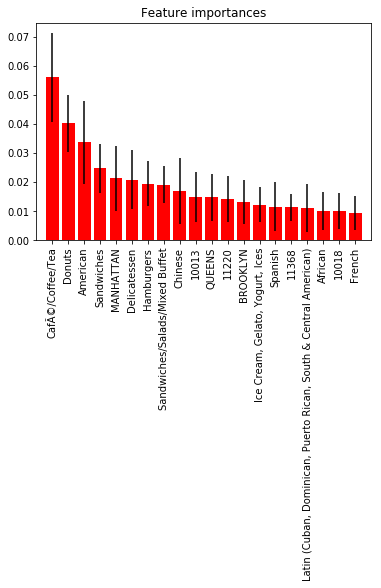

In [188]:
def plotFeatureImportance(tree_obj, n, features):
    importances = tree_obj.feature_importances_
    std = np.std([tree.feature_importances_ for tree in tree_obj.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(n):
        print((f + 1), features[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n), importances[indices[:n]], color="r", yerr=std[indices[:n]], align="center")
    plt.xticks(range(n), features[indices[:n]], rotation=90)
    plt.xlim([-1,n])
    plt.show()

plotFeatureImportance(brf, 20, np.array(Xtrain.columns.values))

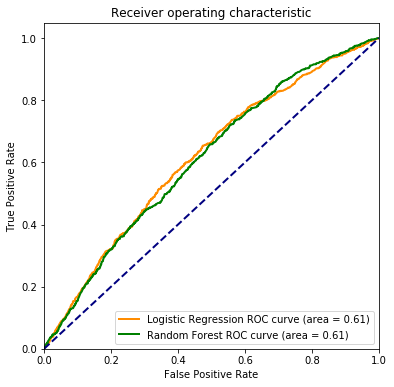

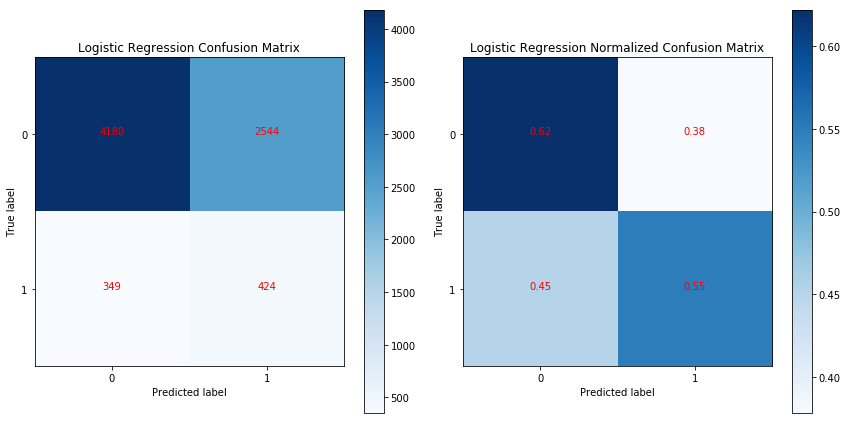

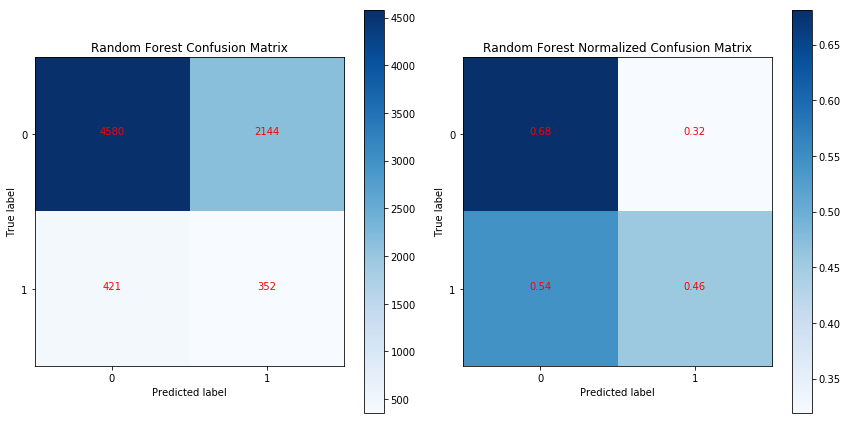

In [157]:
#model performance util functions
def plotLabel(ax):
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('Receiver operating characteristic')
        ax.legend(loc="lower right")



def make_com_roc_curve(g_ypred_pro, yh, g_model):        
        fpr = []
        tpr = []
        roc_auc = []
        n = len(g_ypred_pro)
        for i in range(n):
            ypred_pro1 = g_ypred_pro[i]
            fpr1, tpr1, _ = roc_curve(yh, ypred_pro1[:, 1])
            roc_auc1 = auc(fpr1, tpr1)
            fpr.append(fpr1)
            tpr.append(tpr1)
            roc_auc.append(roc_auc1)
    
        #plt.figure()
        fig, ax = plt.subplots(figsize=(6,6))
        lw = 2
        color = ['darkorange', 'green']
        for i in range(n):
            
            ax.plot(fpr[i], tpr[i], color=color[i], lw=lw, label= g_model[i] + ' ROC curve (area = %0.2f)' % roc_auc[i])
        
        ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plotLabel(ax)
    
        plt.show()

def plotcm(fig, ax, cm, classes, model = '', normalize = False, cmap=plt.cm.Blues):
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            title = model + " Normalized Confusion Matrix"
        else:
            title = model + ' Confusion Matrix'

        img = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.set_title(title)
        fig.colorbar(img, ax=ax)
        #tick_marks = np.arange(len(classes))
        ax.set_xticks(classes) #, rotation=45)
        ax.set_yticks(classes)
        #ax.set_xticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            #color="red" if cm[i, j] > thresh else "black")
            color="red")
        
        ax.set_ylabel('True label')
        ax.set_xlabel('Predicted label')
        
    
def make_confusion_matrix(ypred, yh, model = ""):
        cnf_matrix = confusion_matrix(yh, ypred)
        
        np.set_printoptions(precision=2)
        classes = list(np.unique(yh))
        
        
        #plt.figure()
        fig, (ax1, ax2)= plt.subplots(ncols=2, figsize=(12, 6))
        plotcm(fig, ax1, cnf_matrix, classes, model, False)
        #plt.figure()
        plotcm(fig, ax2, cnf_matrix, classes, model, True)
        
        
        plt.tight_layout()
        plt.show()

ypred_pro1 = blr.predict_proba(Xhold)
ypred_pro2 = brf.predict_proba(Xhold)
ypred1 = blr.predict(Xhold)
ypred2 = brf.predict(Xhold)
model1 = 'Logistic Regression'
model2 = 'Random Forest'
make_com_roc_curve([ypred_pro1, ypred_pro2], yhold, [model1, model2]) 
make_confusion_matrix(ypred1, yhold, model = model1)
make_confusion_matrix(ypred2, yhold, model = model2)